# 层和块
:label:`sec_model_construction`

之前首次介绍神经网络时，我们关注的是具有单一输出的线性模型。
在这里，整个模型只由一个输出。
注意，单个神经网络
（1）接受一些输入；
（2）生成相应的标量输出；
（3）具有一组相关 *参数*（parameters），更新这些参数可以优化某目标函数。

然后，当考虑具有多个输出的网络时，
我们利用矢量化算法来描述整层神经元。
像单个神经元一样，层（1）接受一组输入，
（2）生成相应的输出，
（3）由一组可调整参数描述。
当我们使用softmax回归时，一个单层本身就是模型。
然而，即使我们随后引入了多层感知机，我们仍然可以认为该模型保留了上面所说的基本架构。

对于多层感知机而言，整个模型及其组成层都是这种架构。
整个模型接受原始输入（特征），生成输出（预测），
并包含一些参数（所有组成层的参数集合）。
同样，每个单独的层接收输入（由前一层提供），
生成输出（到下一层的输入），并且具有一组可调参数，
这些参数根据从下一层反向传播的信号进行更新。

事实证明，研究讨论“比单个层大”但“比整个模型小”的组件更有价值。
例如，在计算机视觉中广泛流行的ResNet-152架构就有数百层，
这些层是由*层组*（groups of layers）的重复模式组成。
这个ResNet架构赢得了2015年ImageNet和COCO计算机视觉比赛
的识别和检测任务 :cite:`He.Zhang.Ren.ea.2016`。
目前ResNet架构仍然是许多视觉任务的首选架构。
在其他的领域，如自然语言处理和语音，
层组以各种重复模式排列的类似架构现在也是普遍存在。

为了实现这些复杂的网络，我们引入了神经网络*块*的概念。
*块*（block）可以描述单个层、由多个层组成的组件或整个模型本身。
使用块进行抽象的一个好处是可以将一些块组合成更大的组件，
这一过程通常是递归的，如 :numref:`fig_blocks`所示。
通过定义代码来按需生成任意复杂度的块，
我们可以通过简洁的代码实现复杂的神经网络。

![多个层被组合成块，形成更大的模型](../img/blocks.svg)
:label:`fig_blocks`

从编程的角度来看，块由*类*（class）表示。
它的任何子类都必须定义一个将其输入转换为输出的前向传播函数，
并且必须存储任何必需的参数。
注意，有些块不需要任何参数。
最后，为了计算梯度，块必须具有反向传播函数。
在定义我们自己的块时，由于自动微分（在 :numref:`sec_autograd` 中引入）
提供了一些后端实现，我们只需要考虑前向传播函数和必需的参数。

在构造自定义块之前，(**我们先回顾一下多层感知机**)
（ :numref:`sec_mlp_concise` ）的代码。
下面的代码生成一个网络，其中包含一个具有256个单元和ReLU激活函数的全连接隐藏层，
然后是一个具有10个隐藏单元且不带激活函数的全连接输出层。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[ 0.0022,  0.2543,  0.1424,  0.0649,  0.0264,  0.0498, -0.1257, -0.0281,
         -0.0158,  0.2160],
        [-0.0509,  0.1812,  0.1101,  0.1823,  0.0307,  0.1540, -0.0281, -0.0540,
          0.0681,  0.2564]], grad_fn=<AddmmBackward0>)

在这个例子中，我们通过实例化`nn.Sequential`来构建我们的模型，
层的执行顺序是作为参数传递的。
简而言之，(**`nn.Sequential`定义了一种特殊的`Module`**)，
即在PyTorch中表示一个块的类，
它维护了一个由`Module`组成的有序列表。
注意，两个全连接层都是`Linear`类的实例，
`Linear`类本身就是`Module`的子类。
另外，到目前为止，我们一直在通过`net(X)`调用我们的模型来获得模型的输出。
这实际上是`net.__call__(X)`的简写。
这个前向传播函数非常简单：
它将列表中的每个块连接在一起，将每个块的输出作为下一个块的输入。


## [**自定义块**]

要想直观地了解块是如何工作的，最简单的方法就是自己实现一个。
在实现我们自定义块之前，我们简要总结一下每个块必须提供的基本功能：


1. 将输入数据作为其前向传播函数的参数。
1. 通过前向传播函数来生成输出。请注意，输出的形状可能与输入的形状不同。例如，我们上面模型中的第一个全连接的层接收一个20维的输入，但是返回一个维度为256的输出。
1. 计算其输出关于输入的梯度，可通过其反向传播函数进行访问。通常这是自动发生的。
1. 存储和访问前向传播计算所需的参数。
1. 根据需要初始化模型参数。


在下面的代码片段中，我们从零开始编写一个块。
它包含一个多层感知机，其具有256个隐藏单元的隐藏层和一个10维输出层。
注意，下面的`MLP`类继承了表示块的类。
我们的实现只需要提供我们自己的构造函数（Python中的`__init__`函数）和前向传播函数。


In [2]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params（稍后将介绍）
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # 隐藏层
        self.out = nn.Linear(256, 10)  # 输出层

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 注意，这里我们使用ReLU的函数版本，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))

我们首先看一下前向传播函数，它以`X`作为输入，
计算带有激活函数的隐藏表示，并输出其未规范化的输出值。
在这个`MLP`实现中，两个层都是实例变量。
要了解这为什么是合理的，可以想象实例化两个多层感知机（`net1`和`net2`），
并根据不同的数据对它们进行训练。
当然，我们希望它们学到两种不同的模型。

接着我们[**实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层**]。
注意一些关键细节：
首先，我们定制的`__init__`函数通过`super().__init__()`
调用父类的`__init__`函数，
省去了重复编写模版代码的痛苦。
然后，我们实例化两个全连接层，
分别为`self.hidden`和`self.out`。
注意，除非我们实现一个新的运算符，
否则我们不必担心反向传播函数或参数初始化，
系统将自动生成这些。

我们来试一下这个函数：


In [3]:
net = MLP()
net(X)

tensor([[ 0.3829,  0.0478, -0.0238,  0.0779, -0.2797,  0.1336, -0.0775,  0.0846,
          0.1476, -0.3199],
        [ 0.5808,  0.1228, -0.0382, -0.0478, -0.2856,  0.1796,  0.0510, -0.0248,
          0.0821, -0.2479]], grad_fn=<AddmmBackward0>)

块的一个主要优点是它的多功能性。
我们可以子类化块以创建层（如全连接层的类）、
整个模型（如上面的`MLP`类）或具有中等复杂度的各种组件。
我们在接下来的章节中充分利用了这种多功能性，
比如在处理卷积神经网络时。

## [**顺序块**]

现在我们可以更仔细地看看`Sequential`类是如何工作的，
回想一下`Sequential`的设计是为了把其他模块串起来。
为了构建我们自己的简化的`MySequential`，
我们只需要定义两个关键函数：

1. 一种将块逐个追加到列表中的函数。
1. 一种前向传播函数，用于将输入按追加块的顺序传递给块组成的“链条”。

下面的`MySequential`类提供了与默认`Sequential`类相同的功能。


In [4]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里，module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_modules中。module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

`__init__`函数将每个模块逐个添加到有序字典`_modules`中。
你可能会好奇为什么每个`Module`都有一个`_modules`属性？
以及为什么我们使用它而不是自己定义一个Python列表？
简而言之，`_modules`的主要优点是：
在模块的参数初始化过程中，
系统知道在`_modules`字典中查找需要初始化参数的子块。


当`MySequential`的前向传播函数被调用时，
每个添加的块都按照它们被添加的顺序执行。
现在可以使用我们的`MySequential`类重新实现多层感知机。


In [5]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[ 0.0518, -0.1884,  0.1548,  0.1860, -0.0526, -0.2028, -0.0603,  0.0052,
         -0.1230,  0.1702],
        [ 0.0470, -0.2329,  0.1534,  0.0333,  0.0158, -0.2008, -0.0348, -0.1212,
         -0.2061,  0.2746]], grad_fn=<AddmmBackward0>)

请注意，`MySequential`的用法与之前为`Sequential`类编写的代码相同
（如 :numref:`sec_mlp_concise` 中所述）。

## [**在前向传播函数中执行代码**]

`Sequential`类使模型构造变得简单，
允许我们组合新的架构，而不必定义自己的类。
然而，并不是所有的架构都是简单的顺序架构。
当需要更强的灵活性时，我们需要定义自己的块。
例如，我们可能希望在前向传播函数中执行Python的控制流。
此外，我们可能希望执行任意的数学运算，
而不是简单地依赖预定义的神经网络层。

到目前为止，
我们网络中的所有操作都对网络的激活值及网络的参数起作用。
然而，有时我们可能希望合并既不是上一层的结果也不是可更新参数的项，
我们称之为*常数参数*（constant parameter）。
例如，我们需要一个计算函数
$f(\mathbf{x},\mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}$的层，
其中$\mathbf{x}$是输入，
$\mathbf{w}$是参数，
$c$是某个在优化过程中没有更新的指定常量。
因此我们实现了一个`FixedHiddenMLP`类，如下所示：


In [6]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此其在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

在这个`FixedHiddenMLP`模型中，我们实现了一个隐藏层，
其权重（`self.rand_weight`）在实例化时被随机初始化，之后为常量。
这个权重不是一个模型参数，因此它永远不会被反向传播更新。
然后，神经网络将这个固定层的输出通过一个全连接层。

注意，在返回输出之前，模型做了一些不寻常的事情：
它运行了一个while循环，在$L_1$范数大于$1$的条件下，
将输出向量除以$2$，直到它满足条件为止。
最后，模型返回了`X`中所有项的和。
注意，此操作可能不会常用于在任何实际任务中，
我们只是向你展示如何将任意代码集成到神经网络计算的流程中。


In [7]:
net = FixedHiddenMLP()
net(X)

tensor(-0.1327, grad_fn=<SumBackward0>)

我们可以[**混合搭配各种组合块的方法**]。
在下面的例子中，我们以一些想到的方法嵌套块。


In [8]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.1692, grad_fn=<SumBackward0>)

## 效率


你可能会开始担心操作效率的问题。
毕竟，我们在一个高性能的深度学习库中进行了大量的字典查找、
代码执行和许多其他的Python代码。
Python的问题[全局解释器锁](https://wiki.python.org/moin/GlobalInterpreterLock)
是众所周知的。
在深度学习环境中，我们担心速度极快的GPU可能要等到CPU运行Python代码后才能运行另一个作业。


## 小结

* 一个块可以由许多层组成；一个块可以由许多块组成。
* 块可以包含代码。
* 块负责大量的内部处理，包括参数初始化和反向传播。
* 层和块的顺序连接由`Sequential`块处理。

## 练习

1. 如果将`MySequential`中存储块的方式更改为Python列表，会出现什么样的问题？
1. 实现一个块，它以两个块为参数，例如`net1`和`net2`，并返回前向传播中两个网络的串联输出。这也被称为平行块。
1. 假设你想要连接同一网络的多个实例。实现一个函数，该函数生成同一个块的多个实例，并在此基础上构建更大的网络。


1. 主要区别在于，使用_modules使其他 pytorch 函数/方法能够自动找到添加的层。换句话说，这些图层将被注册。例如，如果要打印网络的参数，只需调用 state_dicts（）。但是，如果采用该列表，则state_dicts之类的方法将不起作用。

2. 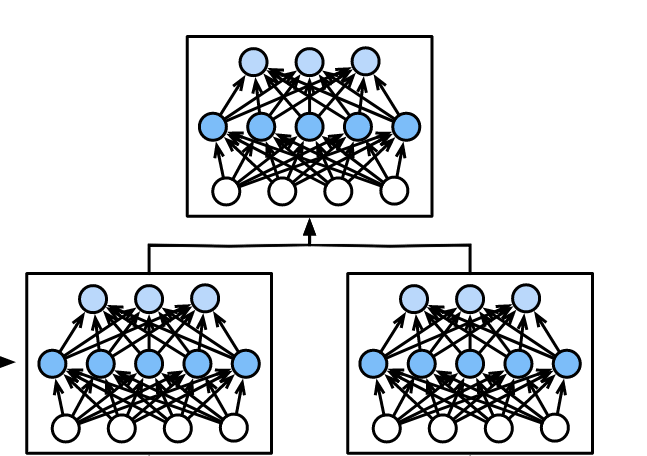

In [ ]:
# 2.
class Bigkuai(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1=nn.Sequential(nn.Linear(20,66),nn.ReLU())
        self.net2=nn.Sequential(nn.Linear(20,33),nn.ReLU())
        
    def forward(self,X):
        x1= self.net1(X)
        x2= self.net2(X)
        x3= torch.cat((x1,x2),dim=1)#两个tensor拼接到一起
        out=nn.Sequential(nn.Linear(x3.shape[0],30)
        return out(x3)

In [ ]:
#3.
class LargeModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = nn.Sequential(nn.Linear(20, 128), nn.ReLU(),
                                 nn.Linear(128, 64), nn.ReLU())
        self.net2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(),
                                 nn.Linear(32, 16), nn.ReLU())
        self.linear = nn.Linear(16, 8)

    def forward(self, X):
        return self.linear(self.net2(self.net1(X))